In [2]:
import os
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [3]:
INPUT_PATH = os.path.join(os.pardir, 'input')

In [4]:
train = pd.read_csv(os.path.join(INPUT_PATH, 'train.csv'), nrows=500)
train.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [5]:
train.columns

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object')

## Target distribution

In [6]:
train['class_label'] = train['target'] >= .5

toxicity_rate = train['class_label'].mean()
print('Class weights:\n\ttoxic:\t\t{:.3f}\n\tnon-toxic:\t{:.3f}'
      .format(toxicity_rate, 1 - toxicity_rate))

Class weights:
	toxic:		0.052
	non-toxic:	0.948


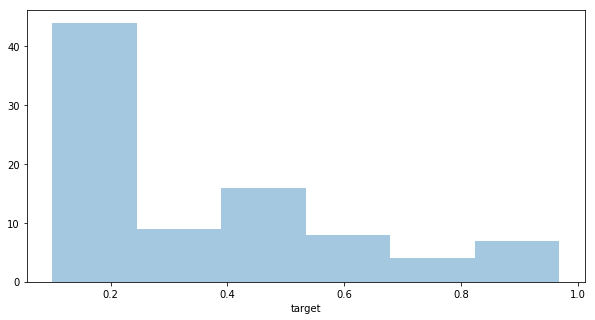

In [7]:
fig, ax = plt.subplots(1, 1, figsize=[10, 5])
sns.distplot(train.loc[train['target'] > 0, 'target'], ax=ax, kde=False)
plt.show()

## What is the identity data like

In [8]:
IDENTITIES = [
    'asian',
    'atheist',
    'bisexual',
    'black',
    'buddhist',
    'christian',
    'female',
    'heterosexual',
    'hindu',
    'homosexual_gay_or_lesbian',
    'intellectual_or_learning_disability',
    'jewish',
    'latino',
    'male',
    'muslim',
    'other_disability',
    'other_gender',
    'other_race_or_ethnicity',
    'other_religion',
    'other_sexual_orientation',
    'physical_disability',
    'psychiatric_or_mental_illness',
    'transgender',
    'white'
]

In [9]:
id_toxic_rate, toxitiy_aimed_at_id_rate, times_mentioned = [], [], []
for identity in IDENTITIES:
    identity_mentioned_df = train[train[identity] > 0]
    id_toxic_rate.append(100 * identity_mentioned_df['target'].mean())
    toxitiy_aimed_at_id_rate.append(100 * identity_mentioned_df['identity_attack'].mean())
    times_mentioned.append(len(train[train[identity] > 0]))
    
toxicity_by_id = pd.DataFrame({'id': IDENTITIES,
                               'times_mentioned': times_mentioned,
                               'general_toxicity_rate': id_toxic_rate,
                               'id_specific_toxicity_rate': toxitiy_aimed_at_id_rate,
                              })
toxicity_by_id.sort_values(by='general_toxicity_rate', ascending=False, inplace=True)

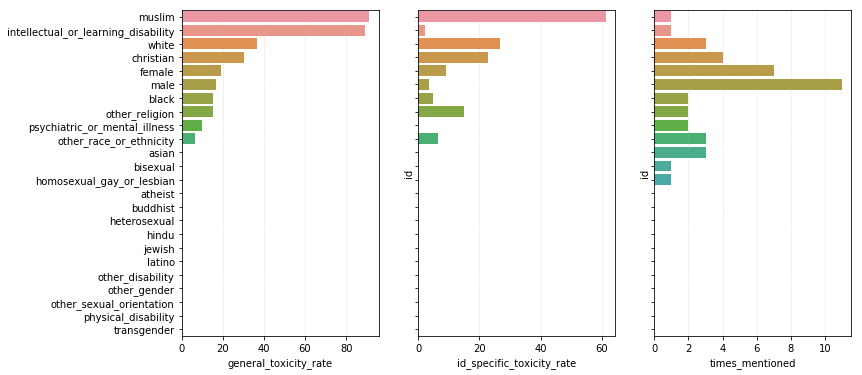

In [10]:
fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=[12, 6], sharey='row')
sns.barplot(data=toxicity_by_id, x='general_toxicity_rate', y='id', ax=ax)
sns.barplot(data=toxicity_by_id, x='id_specific_toxicity_rate', y='id', ax=ax1)
sns.barplot(data=toxicity_by_id, x='times_mentioned', y='id', ax=ax2)

for a in [ax, ax1, ax2]:
    ax.set_ylabel('')
    a.grid(axis='x', linestyle='--', alpha=.3)
plt.show()

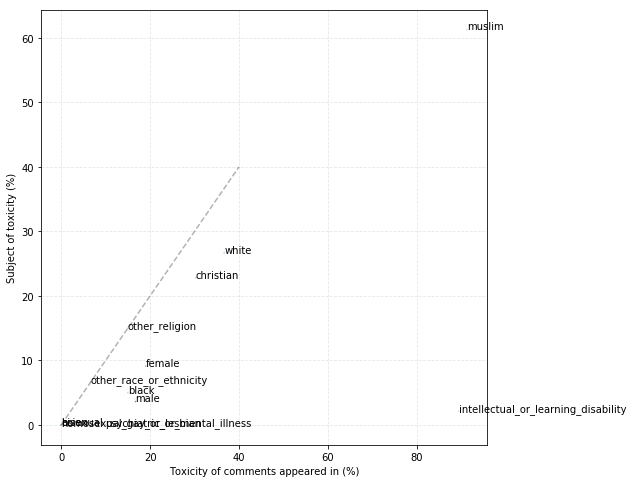

In [11]:
fig, ax = plt.subplots(1, 1, figsize=[8, 8])
non_nan_scores = toxicity_by_id[
    ~toxicity_by_id['general_toxicity_rate'].isnull()
]
ax.scatter(
    non_nan_scores['general_toxicity_rate'], 
    non_nan_scores['id_specific_toxicity_rate'],
    s=non_nan_scores['times_mentioned'] / 20,
    alpha=.6
)
ax.plot([0, 40], [0, 40], color='k', 
        alpha=.3, linestyle='--')

for idx, row in non_nan_scores.iterrows():
    ax.annotate(row['id'], (row['general_toxicity_rate'], row['id_specific_toxicity_rate']))
    
ax.grid(axis='both', linestyle='--', alpha=.3)
ax.set_xlabel('Toxicity of comments appeared in (%)')
ax.set_ylabel('Subject of toxicity (%)')
plt.show()

- How good would individual classifiers be at indicating presence of an identity in comment?
- Learning disability is a good example of an identiy we should be careful with. ~85% of comments it appears in are toxic, but it is the subject of that toxicity in only ~5%.
- Are they toxic *because* they mention learning disabilities or is it inconsequential?